### Imports

In [30]:
### PYMOO
from pymoo.core.problem import Problem, ElementwiseProblem, StarmapParallelization
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.algorithms.moo.spea2 import SPEA2
from pymoo.util.ref_dirs import get_reference_directions
from pymoo.optimize import minimize
from pymoo.operators.sampling.rnd import BinaryRandomSampling
from pymoo.operators.crossover.pntx import TwoPointCrossover
from pymoo.operators.crossover.ux import UniformCrossover
from pymoo.operators.mutation.bitflip import BitflipMutation
from pymoo.util.display.multi import MultiObjectiveOutput
from pymoo.core.sampling import Sampling
from pymoo.core.mutation import Mutation
from pymoo.indicators.hv import HV
from pymoo.termination.max_gen import MaximumGenerationTermination
from pymoo.termination import get_termination
from pymoo.core.crossover import Crossover
from pymoo.util.misc import crossover_mask

#multiprocessamento e outros
from tqdm.notebook import trange, tqdm
import multiprocessing, sys, time, itertools, dill, random, os, pickle, copy

#Pandas, SKLearn e etc.
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#from sklearn import metrics, svm
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
import scipy.stats as stats

### Restrictions

In [31]:
MIN_FEATURES = 1
MAX_FEATURES = 100

### Convergence Plot Functions

In [32]:
def get_hv(result, **kwargs):
    n_evals = np.array([e.evaluator.n_eval for e in result.history])
    opt = np.array([e.opt[0].F for e in result.history])
    X_res, F_res = result.opt.get("X", "F")
            
    hist = result.history
    max = 100
    ref_point = np.array([100, -0.0])
    ind = HV(ref_point=ref_point)
            
    n_evals = []             # corresponding number of function evaluations\
    hist_F = []              # the objective space values in each generation
            
    for algo in hist:
        n_evals.append(algo.evaluator.n_eval)  # store the number of function evaluations
        opt = algo.opt # retrieve the optimum from the algorithm
        # filter out only the feasible and append and objective space values
        feas = np.where(opt.get("feasible"))[0]
        hist_F.append(opt.get("F")[feas])
        
    metric = HV(ref_point= ref_point, norm_ref_point=False)
    hv = [metric.do(_F) for _F in hist_F]
    return n_evals, hv

def plot_convergence(results, **kwargs):
    color = kwargs.get('color', 'black')
    alpha = kwargs.get('alpha', 0.5)
    label = kwargs.get('label', None)
    marker = kwargs.get('marker', 'o')
    ax = kwargs.get('ax', None)
    hvs, n_evals = [], []
    for result in results:
        hv = get_hv(result)
        hvs.extend(hv[1])
        n_evals.extend(hv[0])
    n_evals_rounded = []
    for n_eval in n_evals:
        n_eval = (n_eval + 50) // 100 * 100
        n_evals_rounded.append(n_eval)
    df =  pd.DataFrame({
            "Function Evaluations": n_evals_rounded,
            "Hypervolume": hvs})

    sns.lineplot(data=df, x="Function Evaluations", y="Hypervolume", color = color, label=label, alpha = alpha, ax = ax, linewidth=0.8)
    ax.set_title('Convergence')
    #ax.set_xscale("log")
    #plt.plot(df['n_evals'], df['HV'],  color='black', lw=0.7, label="Avg. CV of Pop", alpha = alpha)
    #plt.scatter(df['n_evals'], df['HV'],  facecolor="none", edgecolor=color, marker="p", alpha = alpha)

### Pareto Front Plot Function

In [33]:
def plot_pareto_front(df, color, marker, label, alpha, ax, **kwargs):
    sns.scatterplot(data = df ,x = 'n_features', y = 'f1_score', color = 'none',  marker=marker, label=label, alpha = alpha, edgecolor=color, linewidth=1.5, s=40, ax = ax)          # Edge thickness
    sns.lineplot(data = df ,x = 'n_features', y = 'f1_score', color = color, legend=False, linewidth=0.5, alpha = alpha, ax = ax)
    return ax

def plot_multiple_pareto_front(results, **kwargs):
    color = kwargs.get('color', 'black')
    title = kwargs.get('title', 'Mean Pareto Front')
    marker = kwargs.get('marker', 'o')
    label = kwargs.get('label', '-')
    alpha = kwargs.get('alpha', 0.7)
    moead = kwargs.get('moead', False)
    ax = kwargs.get('ax', None)
    name = kwargs.get('name', None)
    
    F_res = []
    for result in results:
        F_res.extend(list(result.opt.get("F"))) 
    F_res = np.array(F_res)
    unique_keys = np.unique(F_res[:, 0])
    F_res = np.array([[key, F_res[F_res[:, 0] == key, 1].mean()] for key in unique_keys])
    df = pd.DataFrame({'n_features': F_res[:, 0][np.argsort(F_res[:, 0])],
                      'f1_score': F_res[:, 1][np.argsort(F_res[:, 0])]})
    
    plot_pareto_front(df = df, color = color, marker = marker, label = label, alpha = alpha, ax = ax)
    ax.set_title(title)
    ax.legend(loc="upper right", fontsize=12)
    

def plot_best_pareto_front(results, **kwargs):
    color = kwargs.get('color', 'black')
    title = kwargs.get('title', 'Best Pareto Front')
    marker = kwargs.get('marker', 'o')
    label = kwargs.get('label', '-')
    alpha = kwargs.get('alpha', 0.7)
    moead = kwargs.get('moead', False)
    ax = kwargs.get('ax', None)
    name = kwargs.get('name', None)

    F_res = []
    for result in results:
        F_res.extend(list(result.opt.get("F"))) 
    F_res = find_pareto_frontier(F_res)
    F_res = np.array(F_res)
    unique_keys = np.unique(F_res[:, 0])
    F_res = np.array([[key, F_res[F_res[:, 0] == key, 1].min()] for key in unique_keys])
    df = pd.DataFrame({'n_features': F_res[:, 0][np.argsort(F_res[:, 0])],
                      'f1_score': F_res[:, 1][np.argsort(F_res[:, 0])]})
    plot_pareto_front(df = df, color = color, marker = marker, label = label, alpha = alpha, ax = ax)
    ax.set_title(title)
    ax.legend(loc="upper right",fontsize=12)


def find_pareto_frontier(points):
    unique_points = []
    seen = set()
    for point in points:
        tuple_point = tuple(point)
        if tuple_point not in seen:
            seen.add(tuple_point)
            unique_points.append(point)
    frontier = []
    for p in unique_points:
        is_dominated = False
        for q in unique_points:
            if np.array_equal(q, p):
                continue  # Não comparar o mesmo ponto
            if (np.all(q <= p) and np.any(q < p)):
                is_dominated = True
                break
        if not is_dominated:
            frontier.append(p)
    
    return frontier

In [5]:
def ax_stiles(ax, name, convergence):
    ax.set_title(name[:3], fontsize=18)  # Tamanho da fonte do título
    
    if convergence == True:
        ax.set_xlabel("Function Evaluations", fontsize=14)  # Fonte do eixo X
        ax.set_ylabel("Hypervolume", fontsize=14)  # Fonte do eixo Y
    else:
        ax.set_xlabel("Number of Features", fontsize=14)  # Fonte do eixo X
        ax.set_ylabel("F1 Score", fontsize=14)  # Fonte do eixo Y

    ax.tick_params(axis='both', labelsize=12)
    ax.spines[['right', 'top']].set_visible(False)
    
    ax.tick_params(
        axis='both',          # Aplica a ambos os eixos
        which='both',         # Aplica aos ticks principais e secundários
        bottom=True,          # Mostra ticks no eixo inferior
        left=True,            # Mostra ticks no eixo esquerdo
        top=False,            # Remove ticks no eixo superior
        right=False,          # Remove ticks no eixo direito
        direction='out',      # Direção dos ticks ("out", "in", "inout")
        length=4,             # Comprimento dos ticks
        width=0.5)
    
    ax.grid(
        visible=True,
        axis='y',             # Grade horizontal (ou 'both', 'x')
        linestyle='--',       # Estilo da linha
        linewidth=0.5,
        alpha=0.5,            # Transparência
        color='lightgray')

In [6]:
def plot_convergence_and_pareto_front(results, name):
    colors = {
            'nsga2': 'blue',
            'spea2': 'green',
            'sparseEA': 'orange',
            'mofs_rfga': 'purple',
            'moo-hfs': 'pink',
            'nsga2_weighted': 'red',}
    legend = {
            'nsga2': 'NSGA2',
            'spea2': 'SPEA2',
            'sparseEA': 'SparseEA',
            'mofs_rfga': 'MOFS-RFGA',
            'moo-hfs': 'MOO-HFS',
            'nsga2_weighted': 'EW-MOFS'}
        

    markers = {
            'nsga2': 'o',
            'spea2': '^',
            'sparseEA': 's',
            'mofs_rfga': 'D',
            'moo-hfs': 'p',
            'nsga2_weighted': 'X',}
    
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    for label in results:
        if label == 'nsga2_weighted_norm':
            pass
        else:
            plot_multiple_pareto_front(results[label], color = colors[label], marker = markers[label], label = legend[label], ax = ax1)
    ax_stiles(ax1, name, False)
    fig1.savefig('./Data/results/charts/'+ name +'_mean.pdf', dpi=300, format = 'pdf', pad_inches=0.0)
    
    fig2, ax2 = plt.subplots(figsize=(8, 8))
    for label in results:
        if label == 'nsga2_weighted_norm':
            pass
        else:
            plot_best_pareto_front(results[label], color = colors[label], marker = markers[label], label = legend[label], ax = ax2)
    ax_stiles(ax2, name, False)
    fig2.savefig('./Data/results/charts/'+ name +'_best.pdf', dpi=300, format = 'pdf', pad_inches=0.0)
    
    fig3, ax3 = plt.subplots(figsize=(8, 8))
    for label in results:
        if label == 'nsga2_weighted_norm':
            pass
        else:
            plot_convergence(results[label], color = colors[label], marker = markers[label], label = legend[label], ax = ax3)
    ax_stiles(ax3, name, True)
    fig3.savefig('./Data/results/charts/'+ name +'_conv.pdf', dpi=300, format = 'pdf', pad_inches=0.0)


In [7]:
def get_results_hv(results):
    labels = ['nsga2', 'spea2', 'sparseEA', 'mofs_rfga', 'moo-hfs', 'nsga2_weighted']
    hypervolumes = pd.DataFrame(columns = labels)
    
    for label in labels:
        lista = []
        for result in results[label]:
            lista.append(get_hv(result)[1][-1])
        hypervolumes[label] = lista

    for label in labels:
        if label != 'nsga2_weighted':
            wilcoxon_stat, wilcoxon_p = stats.wilcoxon(hypervolumes[label], hypervolumes['nsga2_weighted'])  # Pareado
            if wilcoxon_p < 0.05 and hypervolumes[label].mean() > hypervolumes['nsga2_weighted'].mean():
                wilcoxon_result = '-'
            elif wilcoxon_p < 0.05 and hypervolumes[label].mean() < hypervolumes['nsga2_weighted'].mean():
                wilcoxon_result = '+'
            else:
                wilcoxon_result = '='
        else:
            wilcoxon_result = ' '
        
        print(round(hypervolumes[label].mean(), 3), '±',round(hypervolumes[label].std(), 3), '/', wilcoxon_result)
        return hypervolumes

def get_initial_hv(results):
    labels = ['nsga2', 'spea2', 'sparseEA', 'mofs_rfga', 'moo-hfs', 'nsga2_weighted']
    hypervolumes = pd.DataFrame(columns = labels)
    
    for label in labels:
        lista = []
        for result in results[label]:
            lista.append(get_hv(result)[1][-0])
        hypervolumes[label] = lista

    for label in labels:
        if label != 'nsga2_weighted':
            wilcoxon_stat, wilcoxon_p = stats.wilcoxon(hypervolumes[label], hypervolumes['nsga2_weighted'])  # Pareado
            if wilcoxon_p < 0.05 and hypervolumes[label].mean() > hypervolumes['nsga2_weighted'].mean():
                wilcoxon_result = '-'
            elif wilcoxon_p < 0.05 and hypervolumes[label].mean() < hypervolumes['nsga2_weighted'].mean():
                wilcoxon_result = '+'
            else:
                wilcoxon_result = '='
        else:
            wilcoxon_result = ' '
        
        print(round(hypervolumes[label].mean(), 3), '±',round(hypervolumes[label].std(), 3), '/', wilcoxon_result)
        return hypervolumes


In [9]:
get_hv(results['nsga2'][0])[1][0]

NameError: name 'results' is not defined

## Resultados

94.028 ± 0.07 / =
86.048 ± 0.914 / +


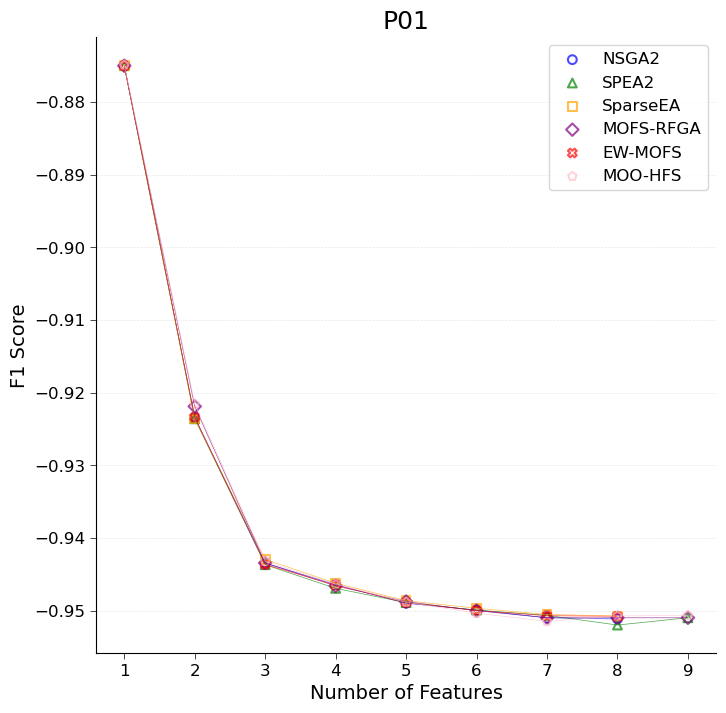

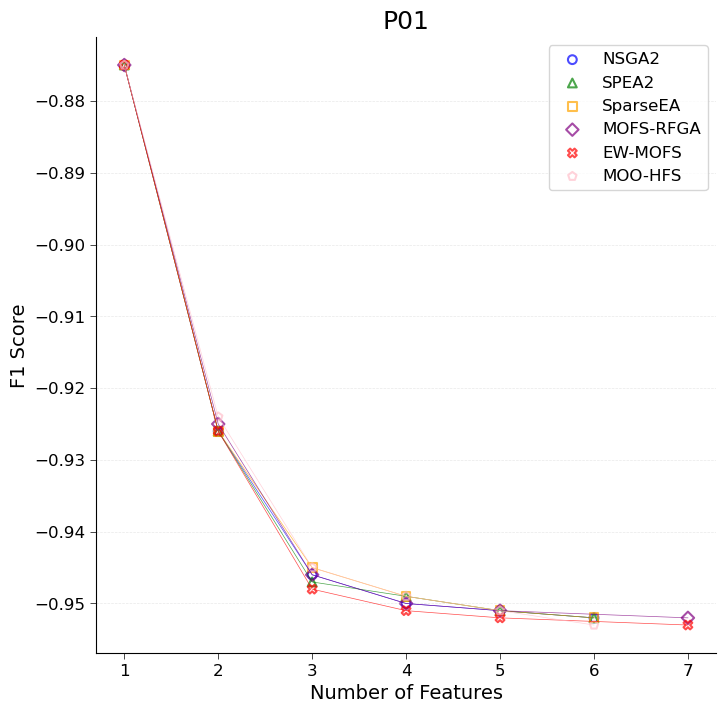

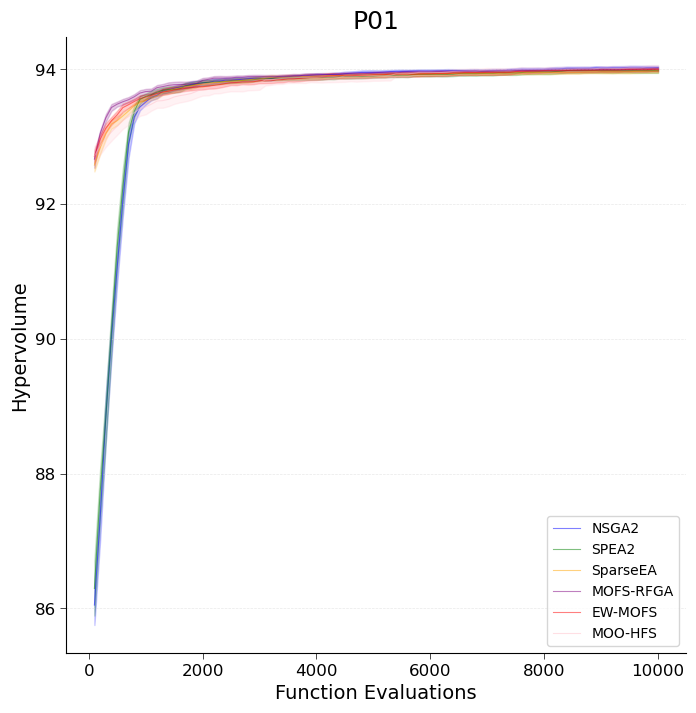

In [46]:
title = 'P01_DT'
with open("Data/results/"+title+".pkl", "rb") as f:  # 'rb' = read in binary mode
    P01 = pickle.load(f)
with open("Data/results/moo_hfs"+title+".pkl", "rb") as f:  # 'rb' = read in binary mode
    P01_moo_hfs = pickle.load(f)
P01['moo-hfs'] = P01_moo_hfs['moo-hfs']

plot_convergence_and_pareto_front(P01, title)
hypervolumes = get_results_hv(P01)
hypervolumes_init = get_initial_hv(P01)
with open('Data/results/HV_'+title+'pkl', 'wb') as handle:
    pickle.dump(hypervolumes, handle)
with open('Data/results/HV_init_'+title+'pkl', 'wb') as handle:
    pickle.dump(hypervolumes_init, handle)

  0%|          | 0/7 [00:00<?, ?it/s]

94.028 ± 0.07 / =
86.048 ± 0.914 / +
83.239 ± 0.067 / =
74.929 ± 1.335 / +
87.604 ± 0.069 / =
69.178 ± 1.468 / +
81.952 ± 0.098 / +
18.483 ± 0.862 / +
92.781 ± 0.128 / =
22.499 ± 1.28 / +
93.127 ± 0.096 / =
22.043 ± 1.224 / +
75.05 ± 0.457 / +
15.63 ± 0.802 / +


/tmp/ipykernel_3390/2913678271.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig3, ax3 = plt.subplots(figsize=(8, 8))


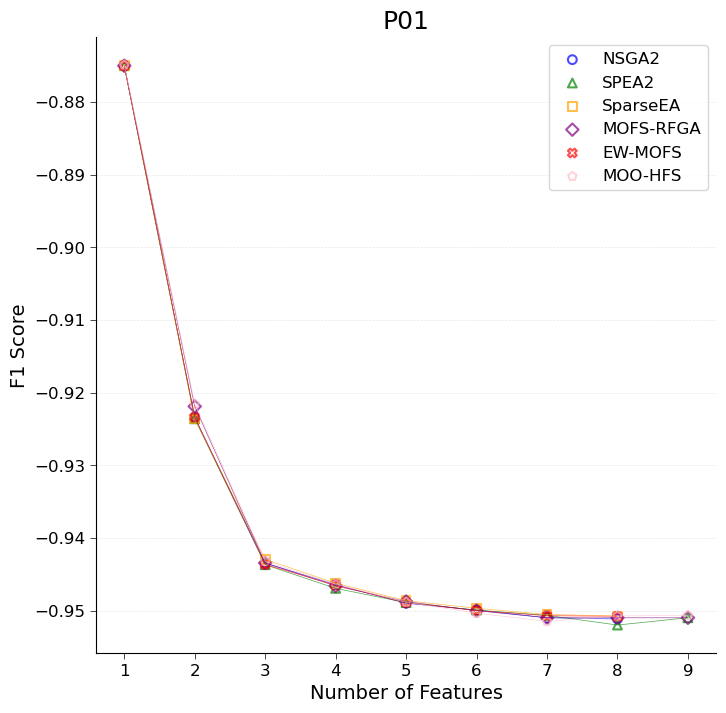

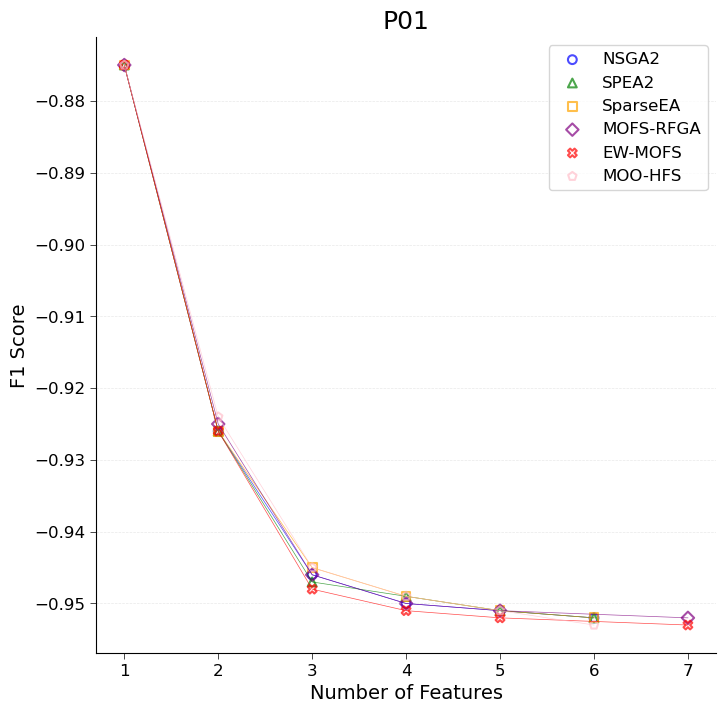

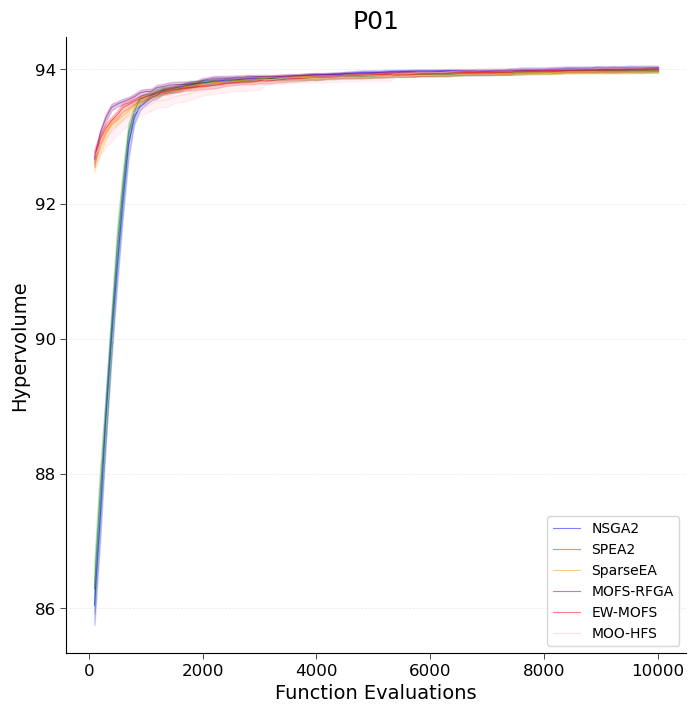

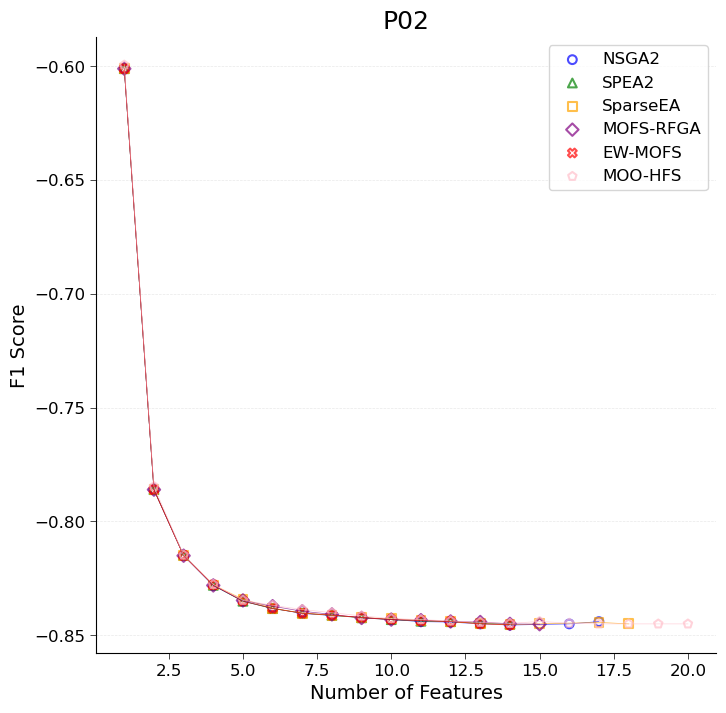

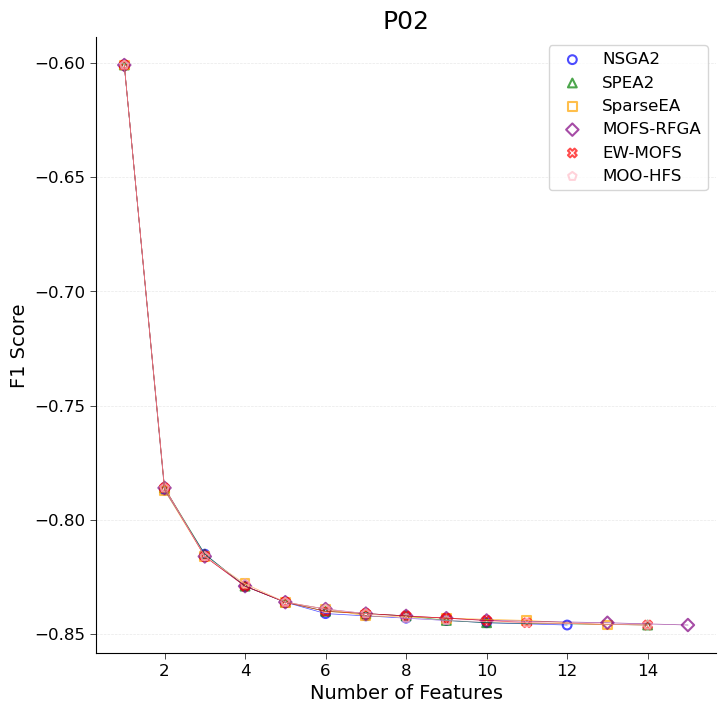

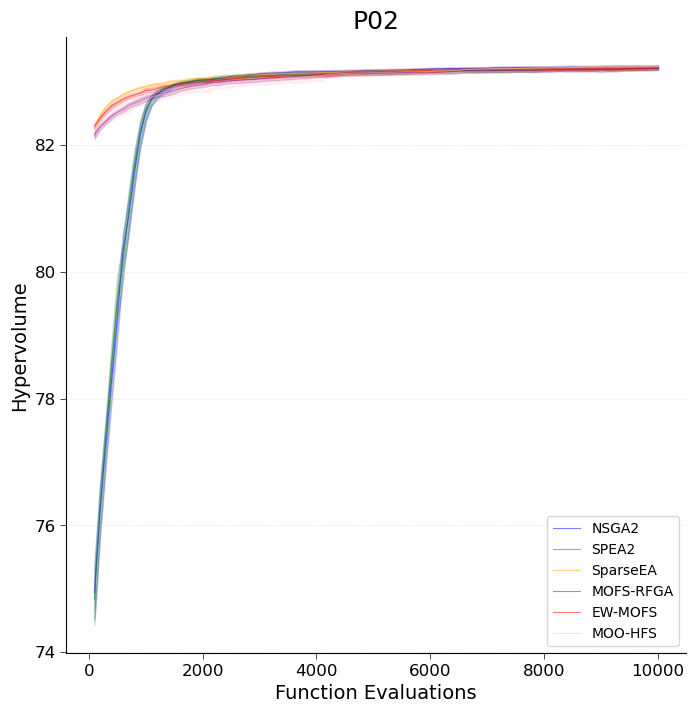

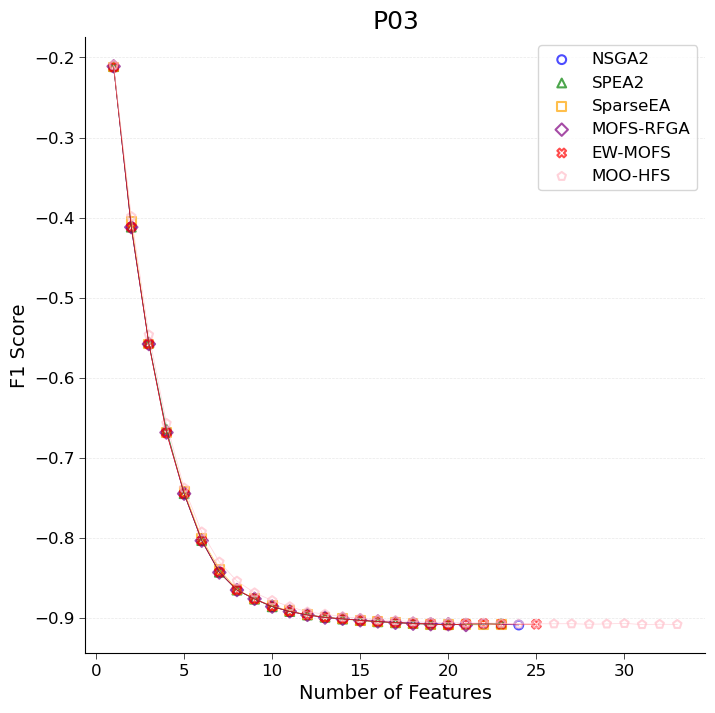

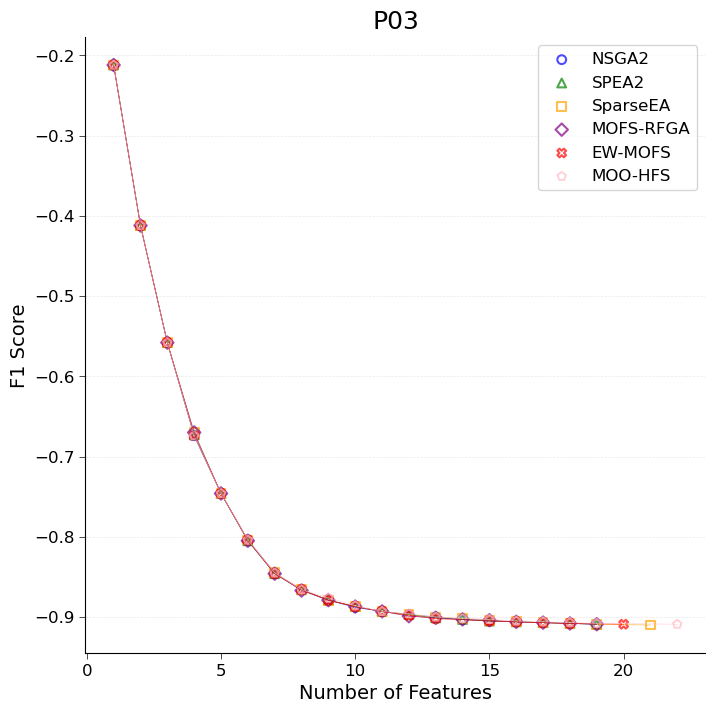

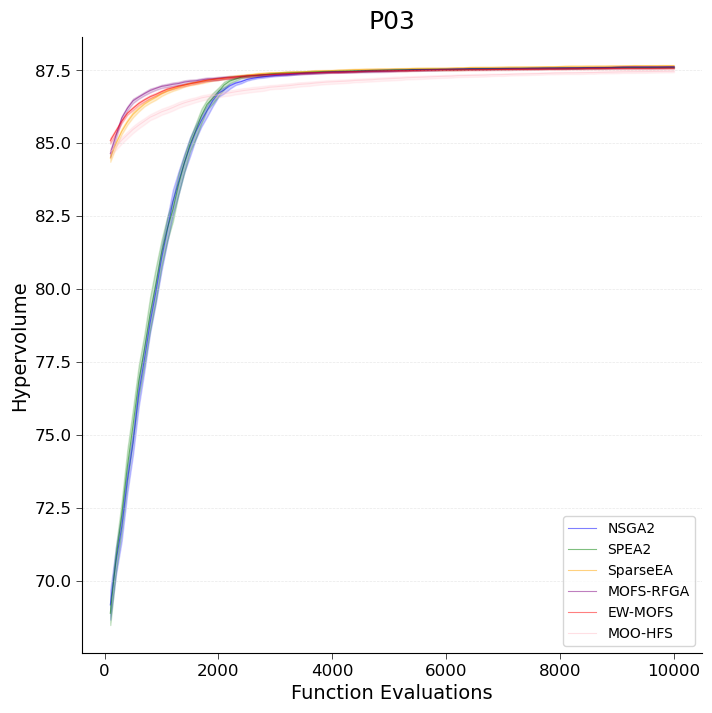

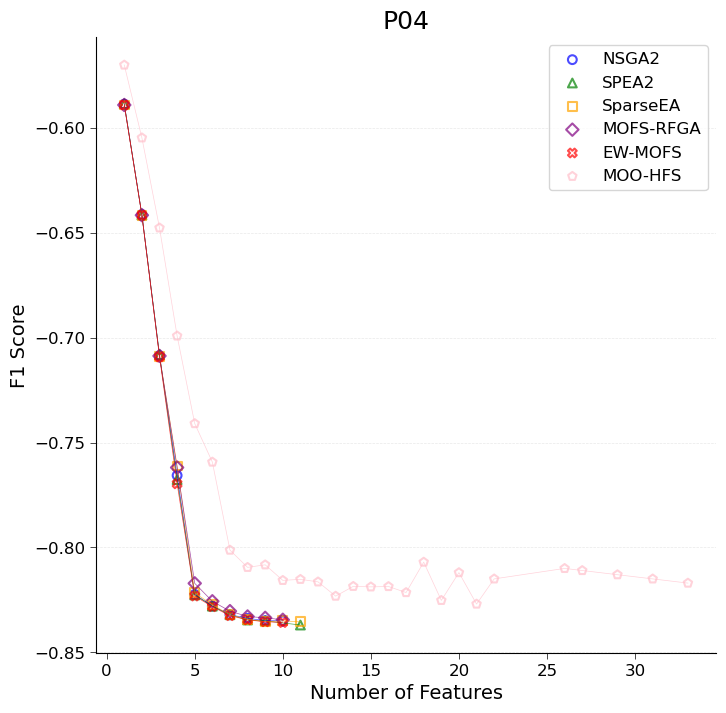

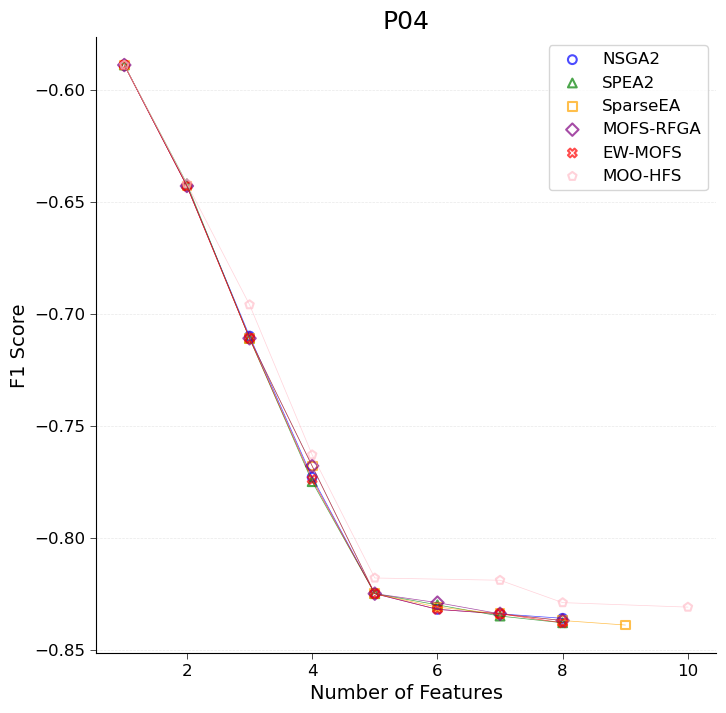

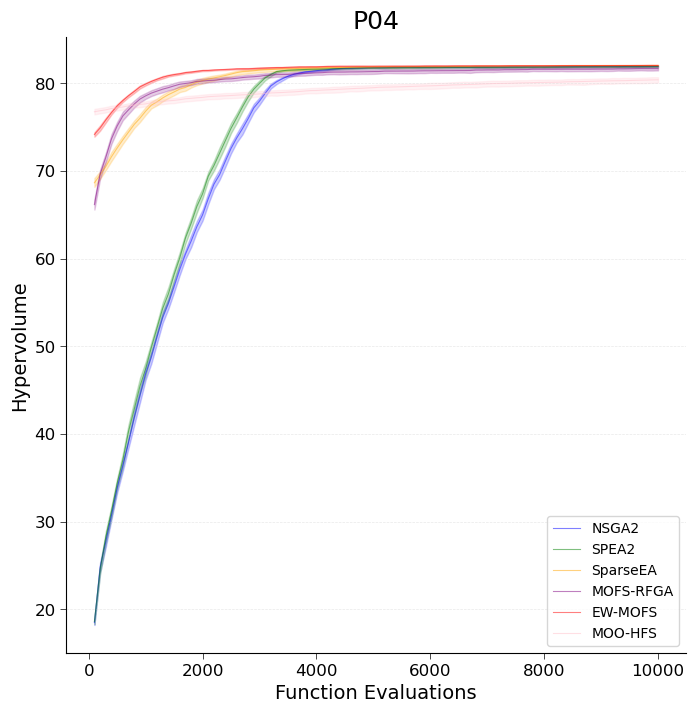

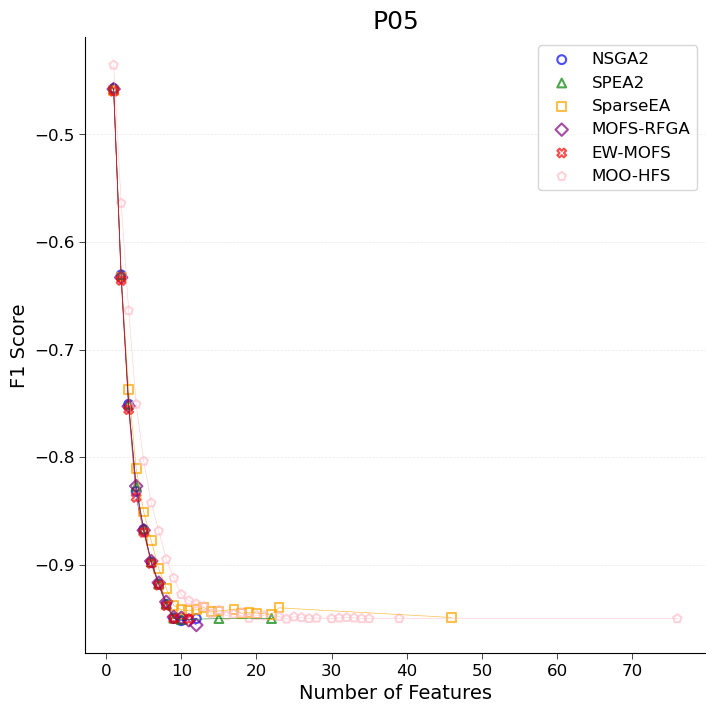

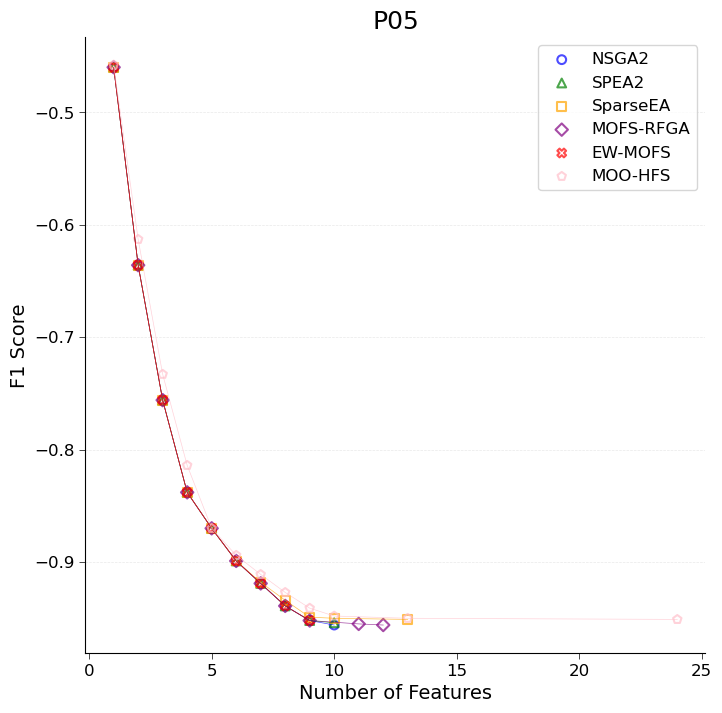

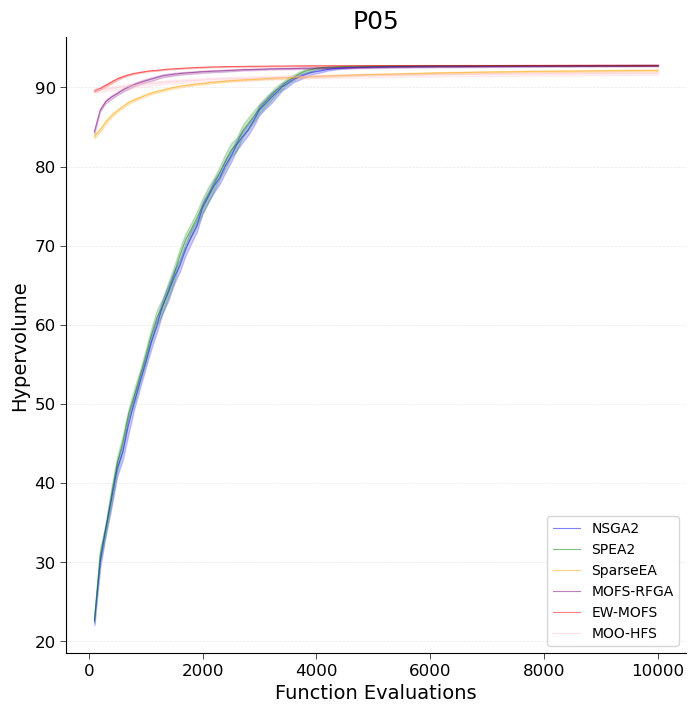

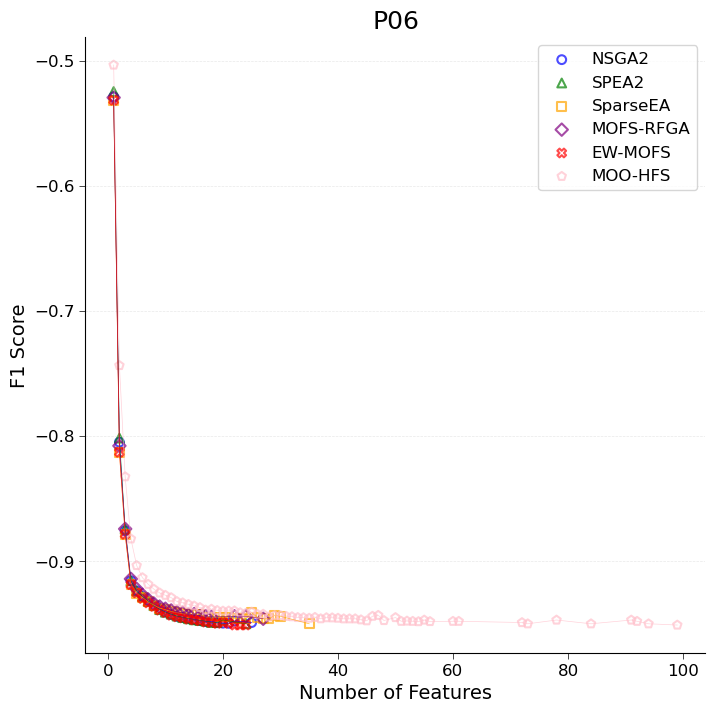

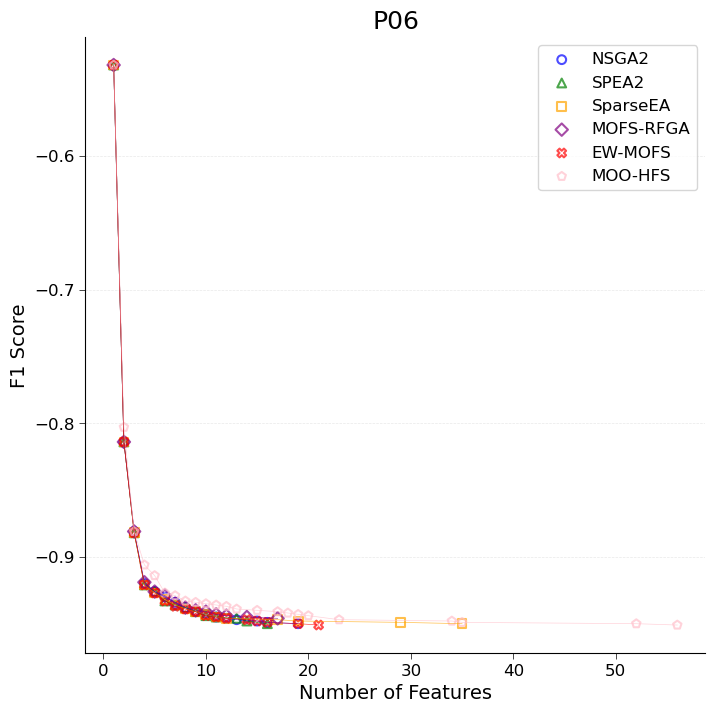

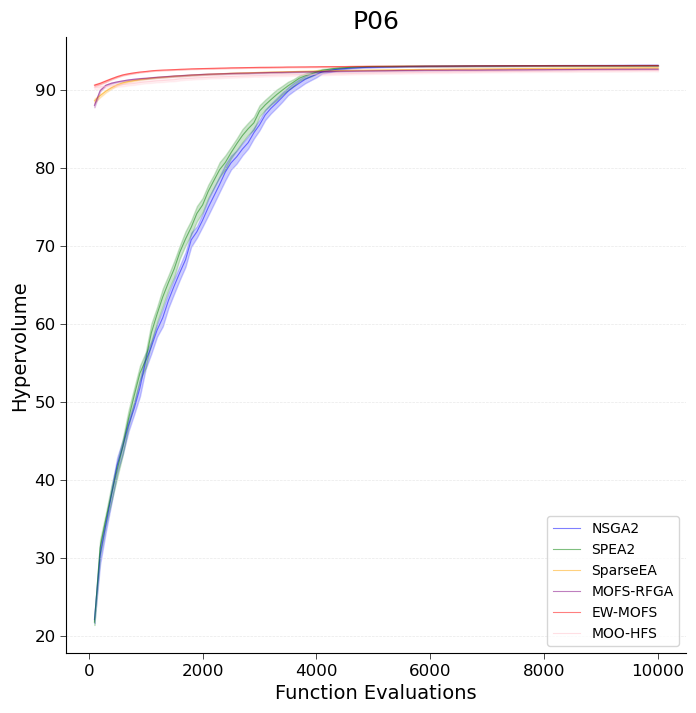

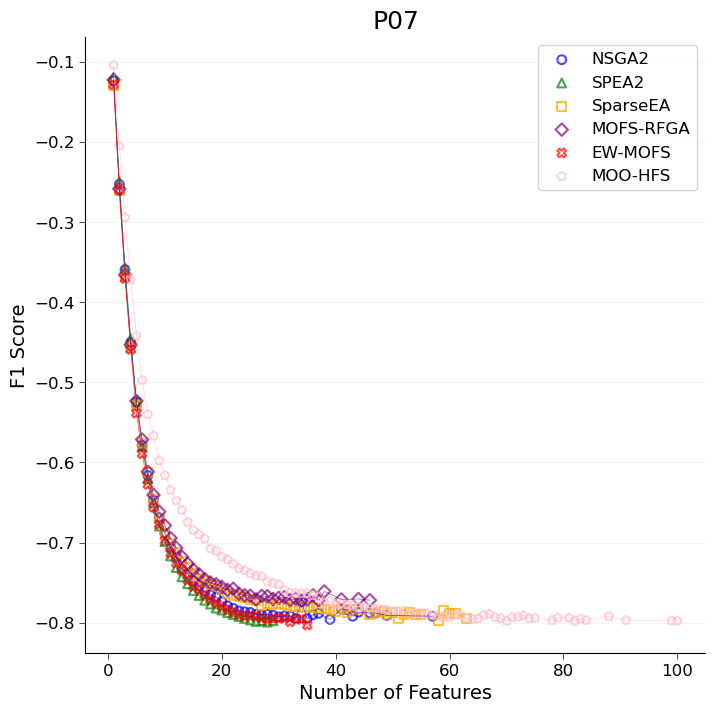

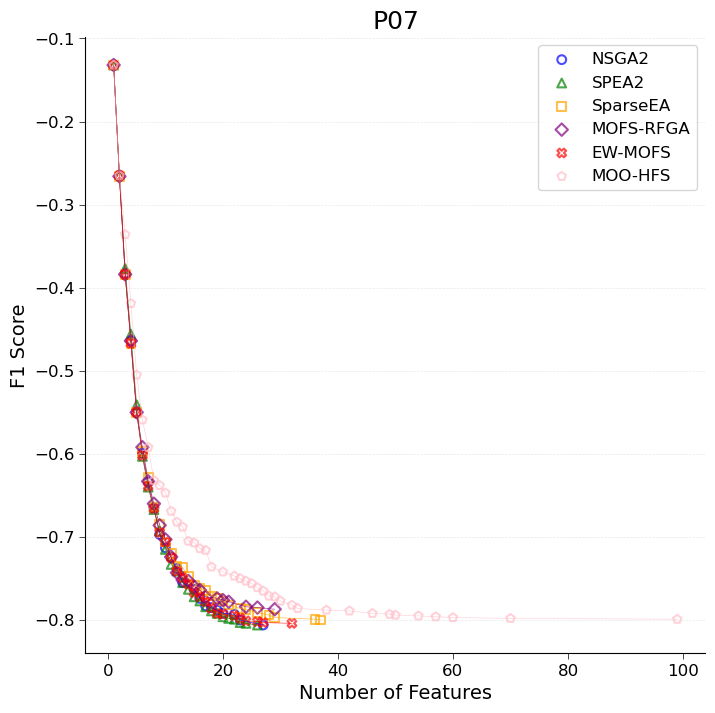

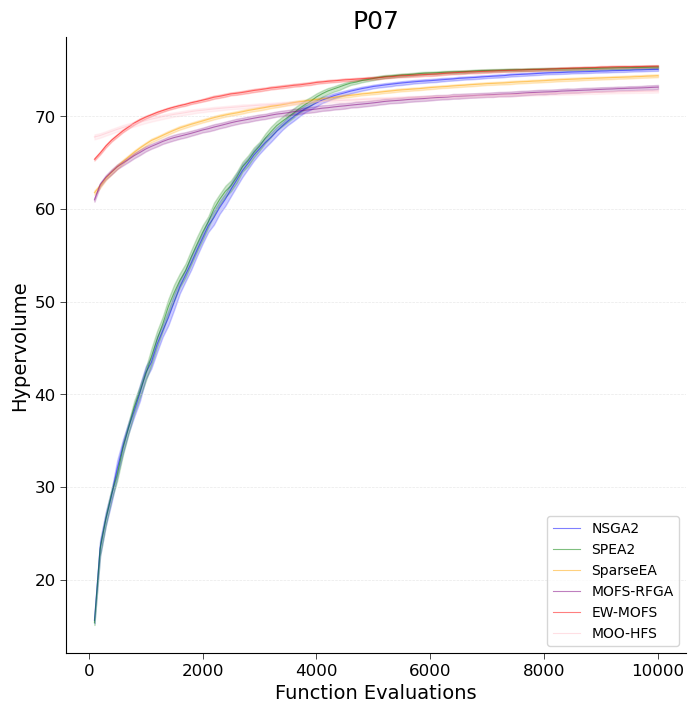

In [66]:
for i in trange(1,8):
    if i<10:
        title = 'P0'+str(i)+'_DT'
    else:
        title = 'P' +str(i)+'_DT'
    with open("Data/results/"+title+".pkl", "rb") as f:  # 'rb' = read in binary mode
        P00 = pickle.load(f)
    with open("Data/results/moo_hfs"+title+".pkl", "rb") as f:  # 'rb' = read in binary mode
        P00_moo_hfs = pickle.load(f)
    P00['moo-hfs'] = P00_moo_hfs['moo-hfs']
    hypervolumes = get_results_hv(P00)
    hypervolumes_init = get_initial_hv(P00)
    plot_convergence_and_pareto_front(P00, title)
    with open('Data/results/HV_'+title+'.pkl', 'wb') as handle:
        pickle.dump(hypervolumes, handle)
    with open('Data/results/HV_init_'+title+'.pkl', 'wb') as handle:
        pickle.dump(hypervolumes_init, handle)

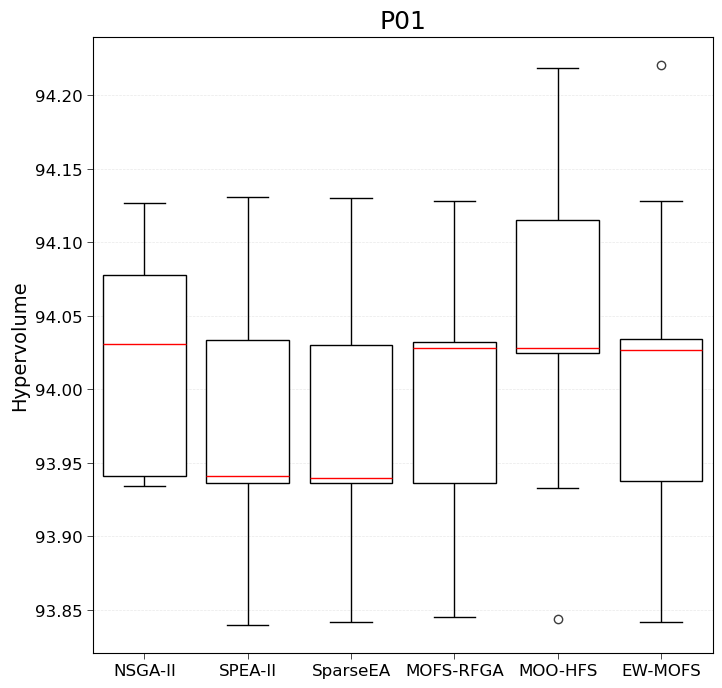

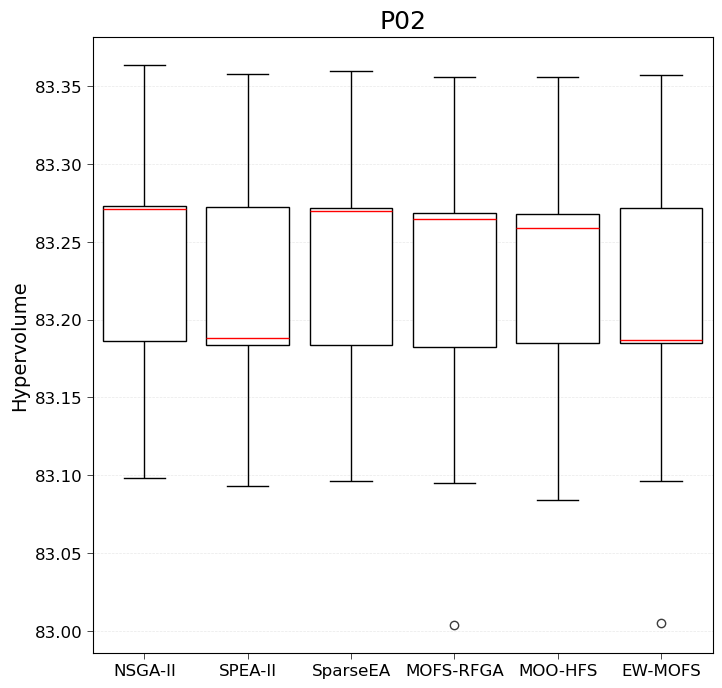

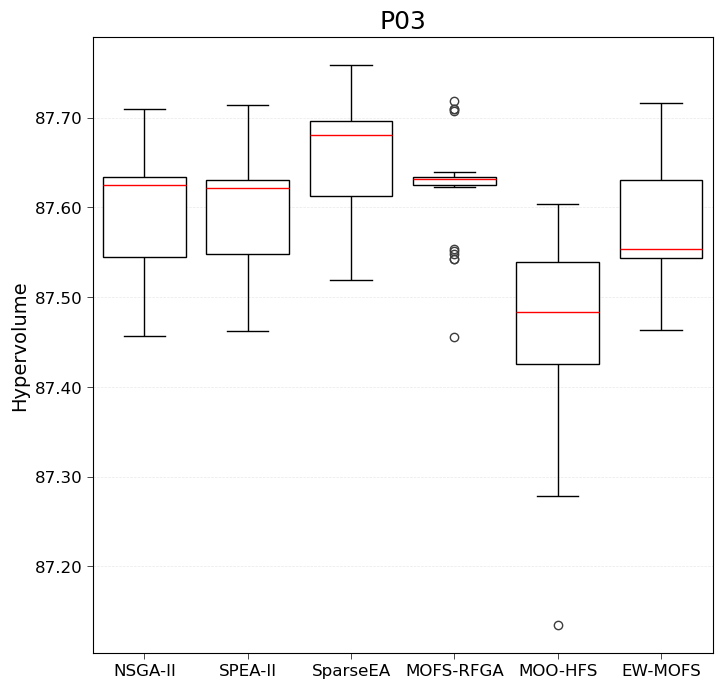

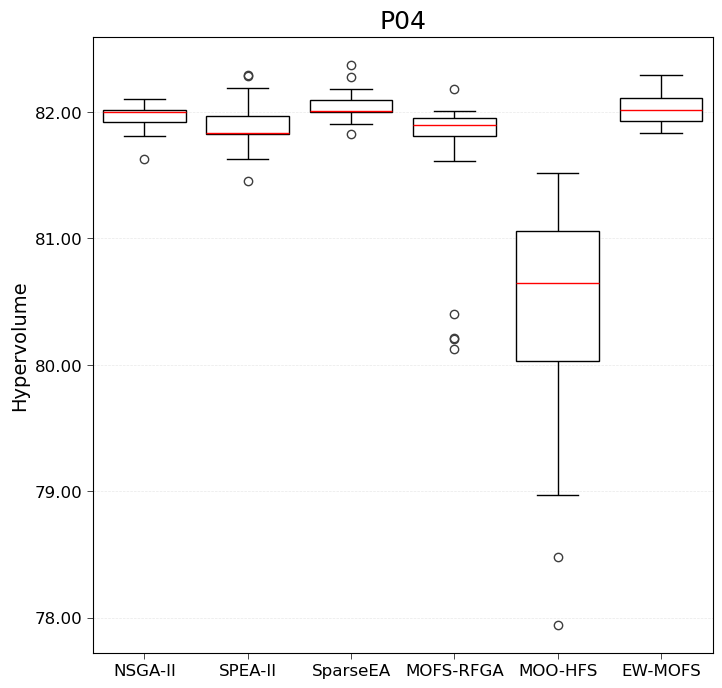

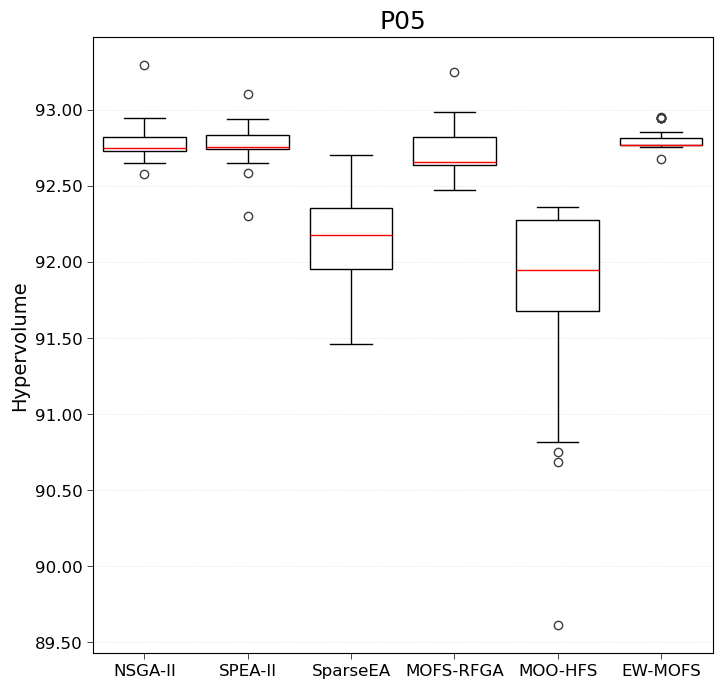

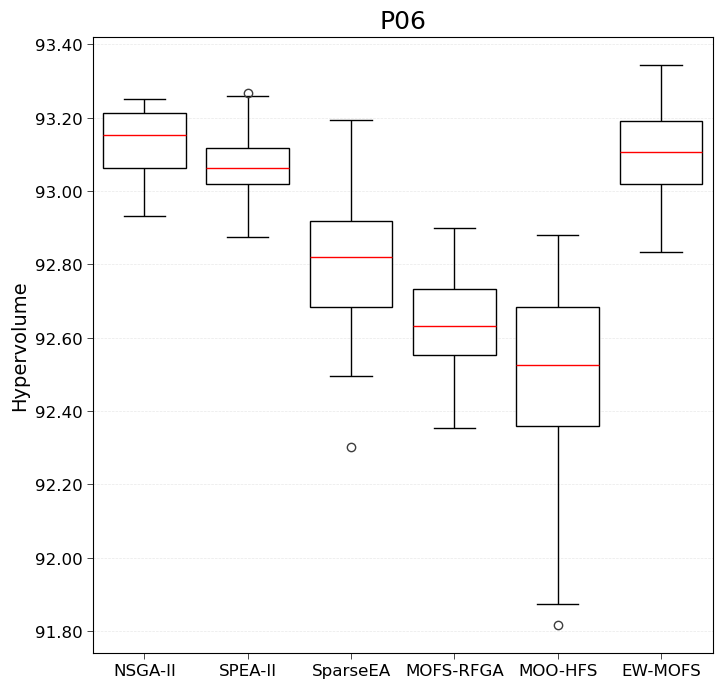

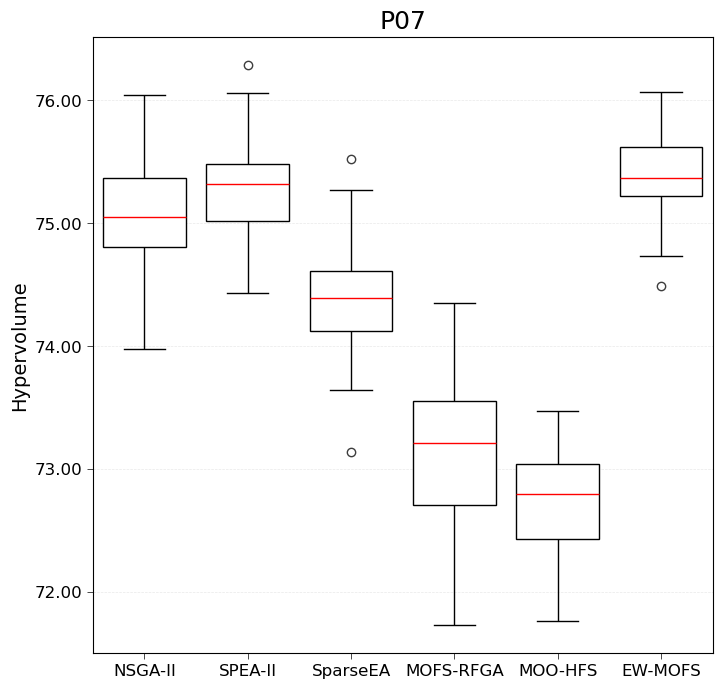

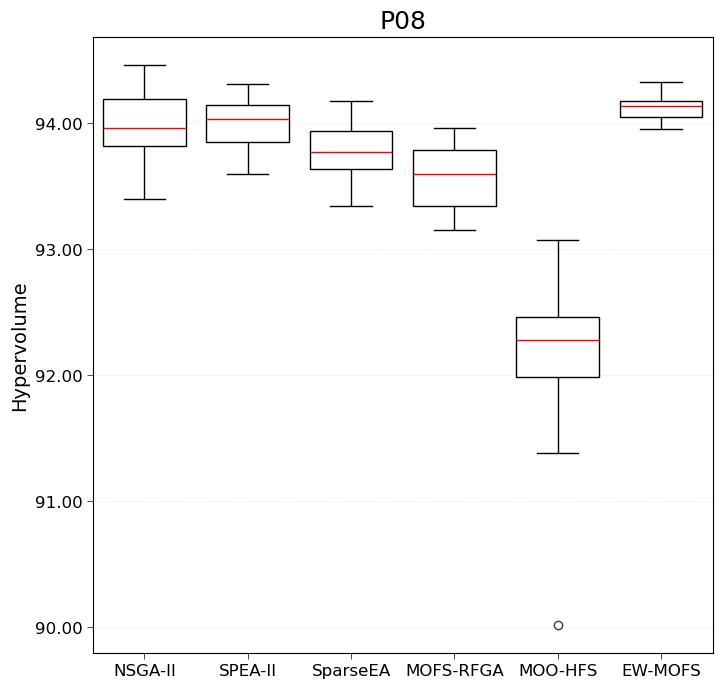

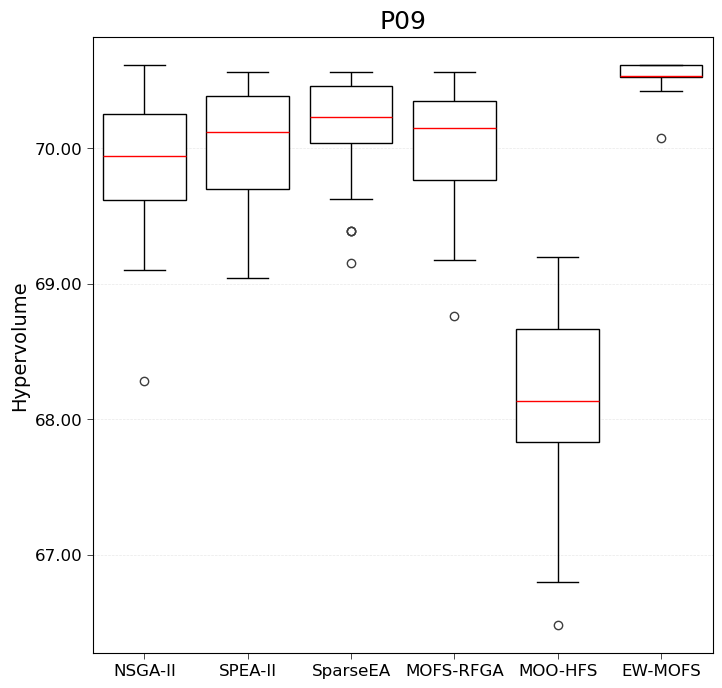

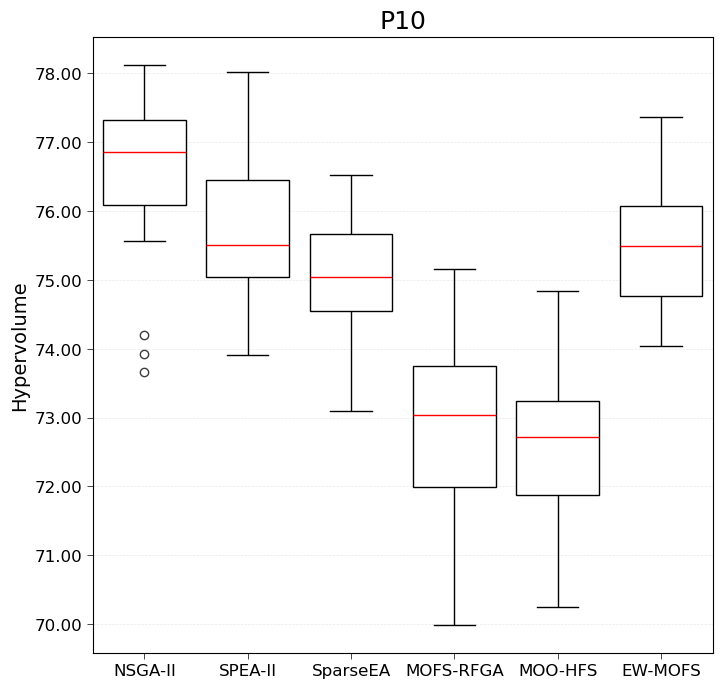

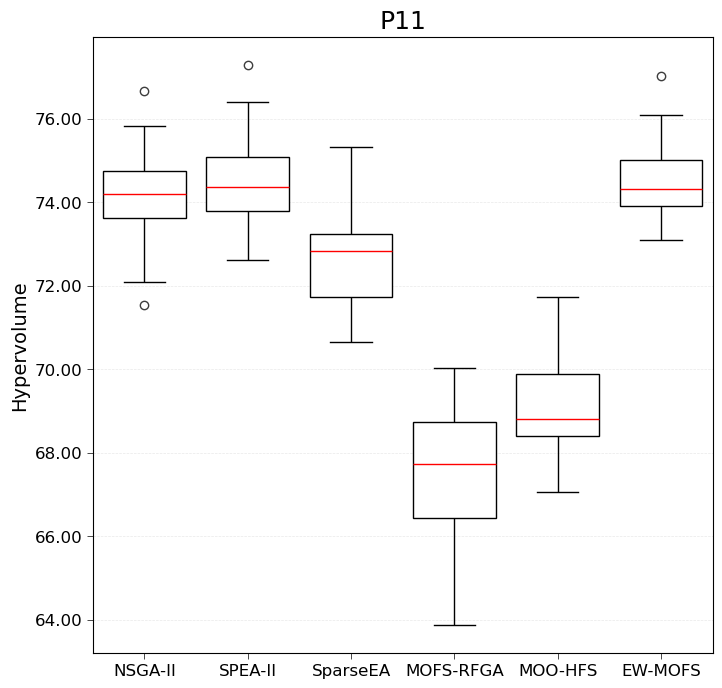

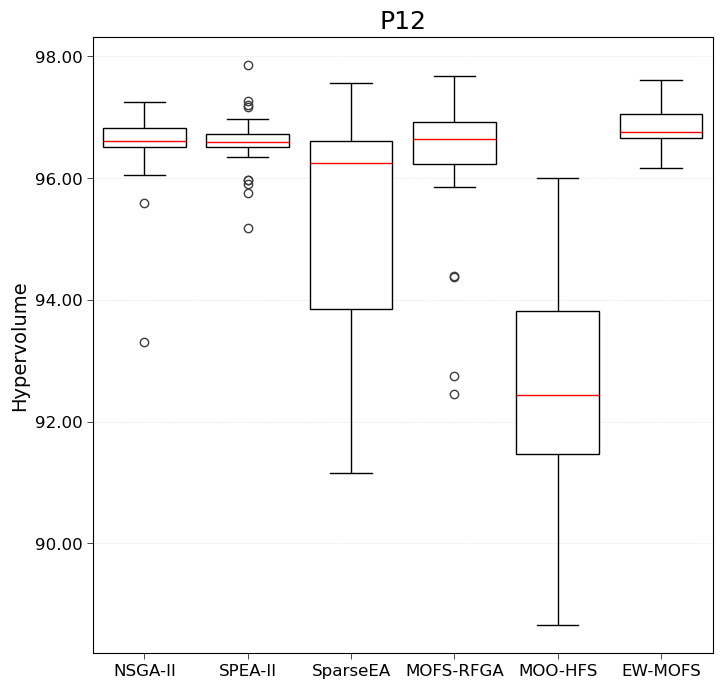

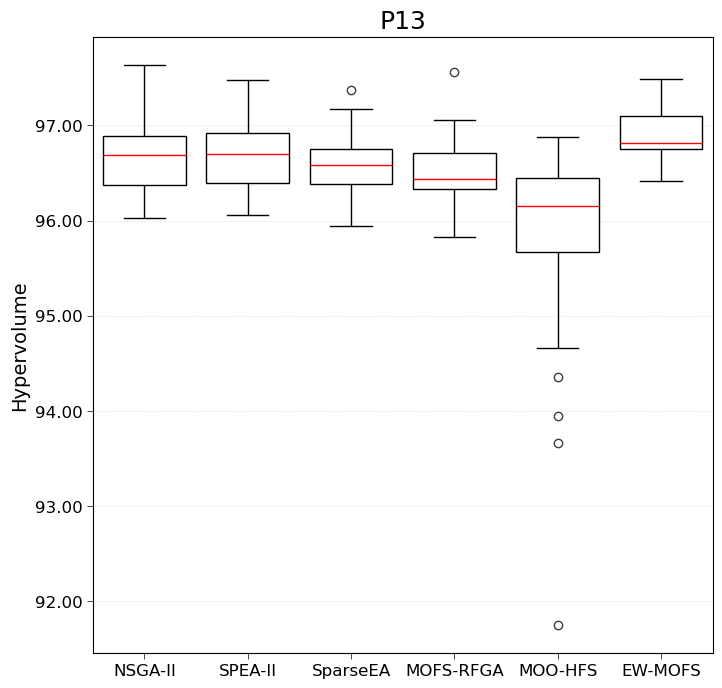

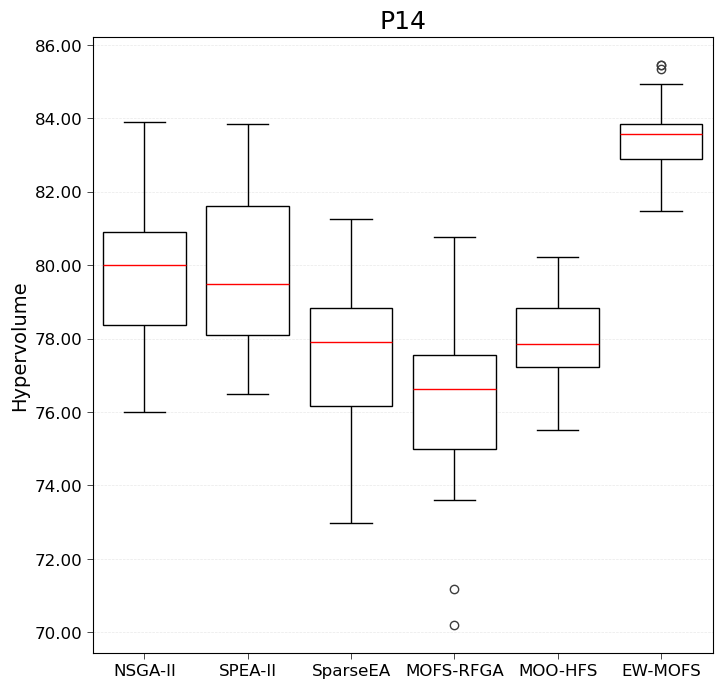

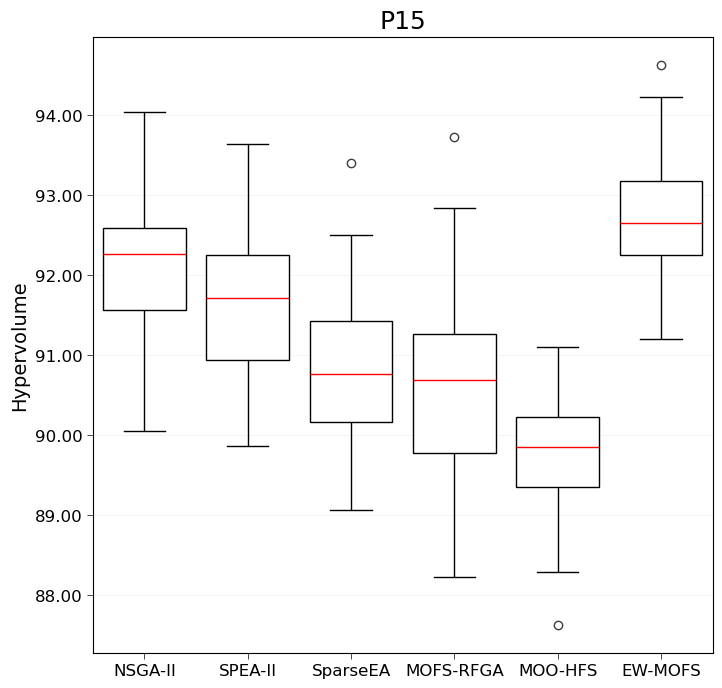

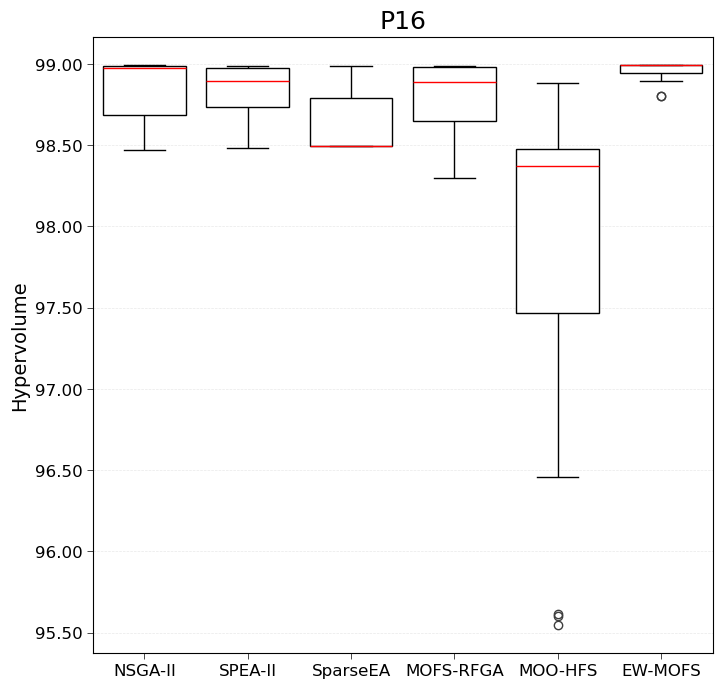

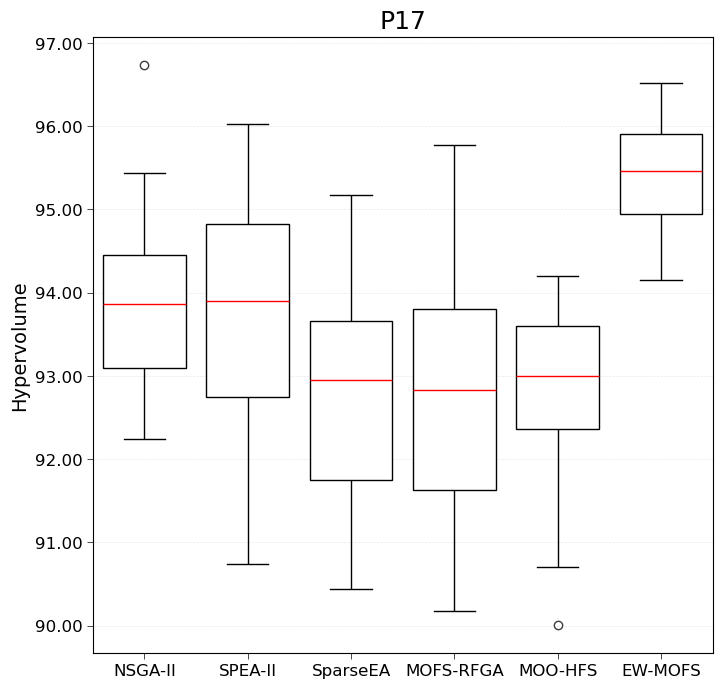

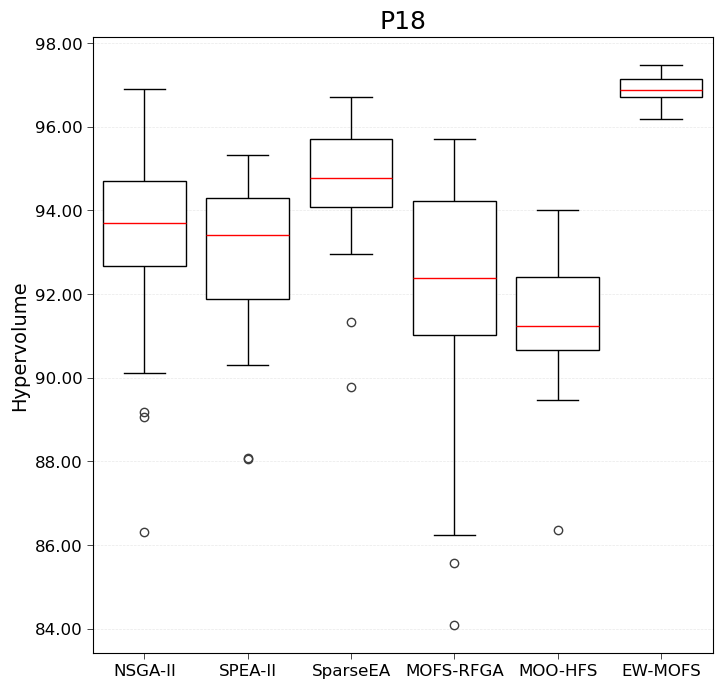

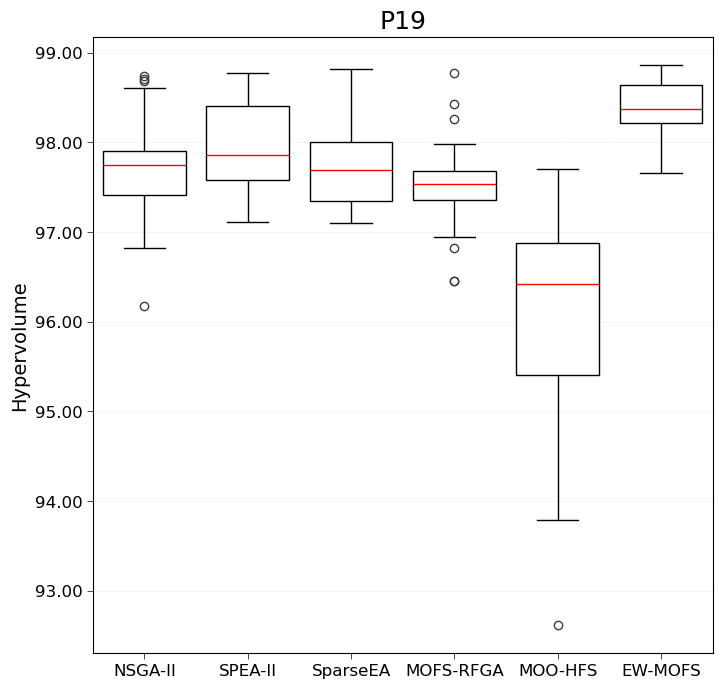

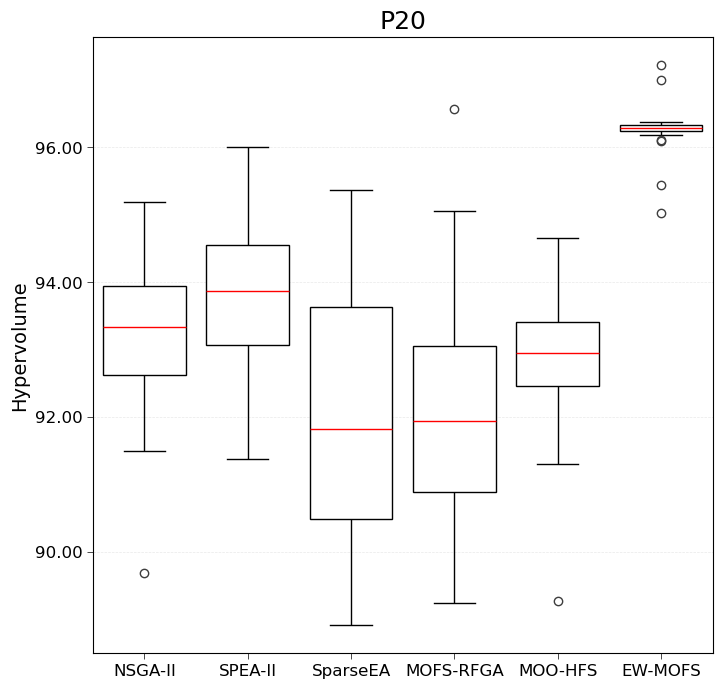

In [29]:
from matplotlib.ticker import FormatStrFormatter  # Importe o formatador
names = []
for i in range(1,10):
    names.append('0' + str(i))
for i in range(10,21):
    names.append(str(i))
for name in names:
    with open('Data/results/HV_P'+name+'_DT.pkl', 'rb') as f:
        hypervolumes = pickle.load(f)
    
    labels=['NSGA-II', 'SPEA-II', 'SparseEA', 'MOFS-RFGA', 'MOO-HFS', 'EW-MOFS']
    fig, ax = plt.subplots(figsize=(8, 8))
    ax = sns.boxplot(
        data=hypervolumes,
        boxprops=dict(facecolor='white', edgecolor='black'),  # Caixa branca com borda preta
        whiskerprops=dict(color='black'),                     # Bigodes pretos
        capprops=dict(color='black'),                         # Linhas das extremidades pretas
        medianprops=dict(color='red', linewidth=1)            # Linha mediana vermelha
    )

    ax.tick_params(axis='both', labelsize=12)
    
    ax.tick_params(
        axis='both',          # Aplica a ambos os eixos
        which='both',         # Aplica aos ticks principais e secundários
        bottom=True,          # Mostra ticks no eixo inferior
        left=True,            # Mostra ticks no eixo esquerdo
        top=False,            # Remove ticks no eixo superior
        right=False,          # Remove ticks no eixo direito
        direction='out',      # Direção dos ticks ("out", "in", "inout")
        length=4,             # Comprimento dos ticks
        width=0.5)
    
    ax.grid(
        visible=True,
        axis='y',             # Grade horizontal (ou 'both', 'x')
        linestyle='--',       # Estilo da linha
        linewidth=0.5,
        alpha=0.5,            # Transparência
        color='lightgray')
    # Personalizar os rótulos do eixo x
    ax.set_xticks(range(len(labels)))  # Garante um FixedLocator
    ax.set_xticklabels(labels)
    #ax.set_ylim(bottom=60, top=100)
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    # Opcional: Remover cores de fundo e ajustar estilo
    ax.set_ylabel("Hypervolume", fontsize=14)  # Fonte do eixo Y
    ax.set_title('P' + name, fontsize=18)
    
    fig.savefig('./Data/results/charts/HV_' + name + '.pdf', dpi=300, format = 'pdf', pad_inches=0.0)

##### 

In [ ]:
with open("Data/results/P02_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P02 = pickle.load(f)
#plot_convergence_and_pareto_front(P02, 'P02_DT')
#get_results_hv(P02)
get_initial_hv(P02)

In [28]:
for i in range(1,21):
    if i>9:
        with open("Data/results/HV_init_P"+str(i)+"_DT.pkl", 'rb') as f:
            hypervolumes = pickle.load(f)
    else:
        with open("Data/results/HV_P0"+str(i)+"_DT.pkl", 'rb') as f:
            hypervolumes = pickle.load(f)
    for label in hv.columns:
            if label != 'nsga2_weighted':
                wilcoxon_stat, wilcoxon_p = stats.wilcoxon(hypervolumes[label], hypervolumes['nsga2_weighted'])  # Pareado
                if wilcoxon_p < 0.05 and hypervolumes[label].mean() > hypervolumes['nsga2_weighted'].mean():
                    wilcoxon_result = '-'
                elif wilcoxon_p < 0.05 and hypervolumes[label].mean() < hypervolumes['nsga2_weighted'].mean():
                    wilcoxon_result = '+'
                else:
                    wilcoxon_result = '='
            else:
                wilcoxon_result = ' '
            
            print(str(round(hypervolumes[label].mean(), 2)), '±', str(round(hypervolumes[label].std(), 2)), wilcoxon_result)
    print('----------------------------------------------')
print(hypervolumes.columns)

86.05 ± 0.91 +
86.29 ± 1.14 +
92.58 ± 0.29 =
92.67 ± 0.33 =
92.71 ± 0.4 =
92.71 ± 0.31  
----------------------------------------------
74.93 ± 1.34 +
74.84 ± 1.16 +
82.26 ± 0.16 =
82.16 ± 0.17 +
82.27 ± 0.27 =
82.3 ± 0.1  
----------------------------------------------
69.18 ± 1.47 +
68.89 ± 1.26 +
84.49 ± 0.37 +
84.64 ± 0.35 +
84.71 ± 0.32 +
85.09 ± 0.28  
----------------------------------------------
18.48 ± 0.86 +
18.59 ± 0.8 +
68.65 ± 1.42 +
66.17 ± 1.68 +
76.76 ± 0.88 -
74.17 ± 0.77  
----------------------------------------------
22.5 ± 1.28 +
22.74 ± 1.27 +
83.79 ± 0.68 +
84.38 ± 0.7 +
89.64 ± 0.9 =
89.56 ± 0.4  
----------------------------------------------
22.04 ± 1.22 +
21.72 ± 1.1 +
88.57 ± 0.72 +
87.97 ± 0.65 +
90.26 ± 0.61 +
90.57 ± 0.34  
----------------------------------------------
15.63 ± 0.8 +
15.39 ± 0.76 +
61.75 ± 0.64 +
60.99 ± 0.58 +
67.77 ± 0.75 -
65.35 ± 0.41  
----------------------------------------------
19.64 ± 1.2 +
19.84 ± 1.39 +
86.26 ± 0.53 +
86.76 ±

In [10]:
with open("Data/results/P03_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P03 = pickle.load(f)
#plot_convergence_and_pareto_front(P03, 'P03_DT')
#get_results_hv(P03)
get_initial_hv(P03)

69.178 ± 1.468 / +
68.891 ± 1.256 / +
84.494 ± 0.375 / +
84.642 ± 0.351 / +
85.086 ± 0.277 /  


In [11]:
with open("Data/results/P04_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P04 = pickle.load(f)
#plot_convergence_and_pareto_front(P04, 'P04_DT')
#get_results_hv(P04)
get_initial_hv(P04)

18.483 ± 0.862 / +
18.59 ± 0.8 / +
68.653 ± 1.423 / +
66.167 ± 1.681 / +
74.166 ± 0.771 /  


In [12]:
with open("Data/results/P05_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P05 = pickle.load(f)
#plot_convergence_and_pareto_front(P05, 'P05_DT')
#get_results_hv(P05)
get_initial_hv(P05)

22.499 ± 1.28 / +
22.741 ± 1.266 / +
83.788 ± 0.678 / +
84.384 ± 0.7 / +
89.561 ± 0.4 /  


In [13]:
with open("Data/results/P06_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P06 = pickle.load(f)
#plot_convergence_and_pareto_front(P06, 'P06_DT')
#get_results_hv(P06)
get_initial_hv(P06)

22.043 ± 1.224 / +
21.718 ± 1.098 / +
88.57 ± 0.718 / +
87.974 ± 0.65 / +
90.573 ± 0.341 /  


In [14]:
with open("Data/results/P07_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P07 = pickle.load(f)
#plot_convergence_and_pareto_front(P07, 'P07_DT')
#get_results_hv(P07)
get_initial_hv(P07)

15.63 ± 0.802 / +
15.385 ± 0.757 / +
61.753 ± 0.645 / +
60.988 ± 0.582 / +
65.355 ± 0.409 /  


In [15]:
with open("Data/results/P08_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P08 = pickle.load(f)
#plot_convergence_and_pareto_front(P08, 'P08_DT')
#get_results_hv(P08)
get_initial_hv(P08)

19.645 ± 1.197 / +
19.839 ± 1.386 / +
86.26 ± 0.53 / +
86.765 ± 0.619 / +
90.049 ± 0.512 /  


In [16]:
with open("Data/results/P09_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P09 = pickle.load(f)
#plot_convergence_and_pareto_front(P09, 'P09_DT')
#get_results_hv(P09)
get_initial_hv(P09)

8.328 ± 0.687 / +
8.774 ± 0.666 / +
41.503 ± 1.57 / +
41.134 ± 1.687 / +
64.75 ± 0.652 /  


In [17]:
with open("Data/results/P10_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P10 = pickle.load(f)
#plot_convergence_and_pareto_front(P10, 'P10_DT')
#get_results_hv(P10)
get_initial_hv(P10)

10.542 ± 0.774 / +
10.681 ± 0.948 / +
62.565 ± 0.768 / +
63.596 ± 0.678 / +
65.857 ± 0.946 /  


In [18]:
with open("Data/results/P11_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P11 = pickle.load(f)
#plot_convergence_and_pareto_front(P11, 'P11_DT')
#get_results_hv(P11)
get_initial_hv(P11)

7.331 ± 0.373 / +
7.642 ± 0.622 / +
46.457 ± 0.692 / +
44.522 ± 1.158 / +
56.416 ± 0.653 /  


In [19]:
with open("Data/results/P12_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P12 = pickle.load(f)
#plot_convergence_and_pareto_front(P12, 'P12_DT')
#get_results_hv(P12)
get_initial_hv(P12)

7.8 ± 0.753 / +
8.336 ± 0.844 / +
78.69 ± 1.978 / +
78.544 ± 2.526 / +
81.596 ± 1.821 /  


In [20]:
with open("Data/results/P13_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P13 = pickle.load(f)
#plot_convergence_and_pareto_front(P13, 'P13_DT')
#get_results_hv(P13)
get_initial_hv(P13)

2.01 ± 0.36 / +
2.101 ± 0.418 / +
90.296 ± 0.866 / +
90.173 ± 0.822 / +
92.874 ± 0.958 /  


In [21]:
with open("Data/results/P14_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P14 = pickle.load(f)
#plot_convergence_and_pareto_front(P14, 'P14_DT')
#get_results_hv(P14)
get_initial_hv(P14)

1.24 ± 0.222 / +
1.39 ± 0.287 / +
53.429 ± 0.904 / +
53.784 ± 1.542 / +
67.514 ± 1.339 /  


In [22]:
with open("Data/results/P15_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P15 = pickle.load(f)
#plot_convergence_and_pareto_front(P15, 'P15_DT')
#get_results_hv(P15)
get_initial_hv(P15)

1.58 ± 0.404 / +
1.661 ± 0.309 / +
78.589 ± 0.851 / +
78.921 ± 1.186 / +
83.204 ± 1.361 /  


In [23]:
with open("Data/results/P16_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P16 = pickle.load(f)
#plot_convergence_and_pareto_front(P16, 'P16_DT')
#get_results_hv(P16)
get_initial_hv(P16)

1.694 ± 0.427 / +
1.805 ± 0.324 / +
96.288 ± 0.667 / +
95.435 ± 0.953 / +
98.042 ± 0.708 /  


In [24]:
with open("Data/results/P17_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P17 = pickle.load(f)
#plot_convergence_and_pareto_front(P17, 'P17_DT')
#get_results_hv(P17)
get_initial_hv(P17)

1.357 ± 0.387 / +
1.429 ± 0.395 / +
79.185 ± 1.129 / +
78.966 ± 1.131 / +
82.618 ± 1.441 /  


In [10]:
with open("Data/results/P18_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P18 = pickle.load(f)
#plot_convergence_and_pareto_front(P18, 'P18_DT')
#get_results_hv(P18)
get_initial_hv(P18)

1.21 ± 0.246 / +
1.198 ± 0.231 / +
67.917 ± 1.949 / +
67.859 ± 1.785 / +
82.895 ± 1.852 /  


In [11]:
with open("Data/results/P19_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P19 = pickle.load(f)
#plot_convergence_and_pareto_front(P19, 'P19_DT')
#get_results_hv(P19)
get_initial_hv(P19)

1.443 ± 0.386 / +
1.676 ± 0.213 / +
86.31 ± 1.471 / +
87.786 ± 1.756 / +
94.838 ± 0.973 /  


In [12]:
with open("Data/results/P20_DT.pkl", "rb") as f:  # 'rb' = read in binary mode
    P20 = pickle.load(f)
#plot_convergence_and_pareto_front(P20, 'P20_DT')
#get_results_hv(P20)
get_initial_hv(P20)

1.299 ± 0.249 / +
1.312 ± 0.305 / +
70.028 ± 1.698 / +
71.572 ± 1.704 / +
84.514 ± 1.397 /  
